# Automate Terraform with GitHub Actions

GitHub Actions add continuous integration to GitHub repositories to automate your software builds, tests, and deployments. Automating Terraform with CI/CD enforces configuration best practices, promotes collaboration and automates the Terraform workflow.

HashiCorp's "[Setup Terraform](https://github.com/marketplace/actions/hashicorp-setup-terraform)" GitHub Action sets up and configures the Terraform CLI in your Github Actions workflow. This allows most Terraform commands to work exactly like they do on your local command line.

In this tutorial, you will set up a complete GitHub Actions workflow to deploy a publicly accessible web server within a Terraform Cloud workspace.

<img alt=Terraform Cloud and GitHub Actions Workflow src=https://learn.hashicorp.com/img/terraform/automation/tfc-gh-actions-workflow.png width=640>

The workflow will:

1. check whether the configuration is formatted properly to demonstrate how you can enforce best practices
2. generate a plan for every pull requests
3. apply the configuration when you update the `main` branch

Then, you will create and merge a pull request to test the workflow.

Terraform Cloud's built-in support for GitHub webhooks can accomplish this generic workflow. However, by performing the run from an Actions workflow, you can customize the workflow by adding additional steps before and after your Terraform commands.

## Prerequisites

For this tutorial, you will need:

- A [GitHub account](https://github.com/join)
- A [Terraform Cloud account](https://app.terraform.io)
<!-- - An [AWS account](https://aws.amazon.com/account/) and AWS Access Credentials
 -->

<!-- If you don't have AWS Access Credentials, create your AWS Access Key ID and Secret Access Key by navigating to your [IAM security credentials](https://console.aws.amazon.com/iam/home?#/security_credentials) in the AWS console. Click "Create access key" here and download the file. This file contains your access credentials. -->

<!-- > **Note:** This tutorial will provision resources that qualify under the [AWS free-tier](https://aws.amazon.com/free/). If your account doesn't qualify under the AWS free-tier, we're not responsible for any charges that you may incur. -->

## Set up Terraform Cloud

The GitHub Action you create will connect to Terraform Cloud to plan and apply your configuration. Before we set up the Actions workflow, you must:
* create a workspace
* generate a user API token.
<!-- * add your AWS service credentials to your Terraform Cloud workspace -->

### Create Terraform Cloud Workspace

<details><summary>Terraform Cloud Workspace</summary>

* First, create a new Terraform Cloud workspace named `gh-actions-demo`.
    * Go to the Create a new Workspace page - Workspaces and click "New Workspace".
	* Select "**API-driven workflow**".
	* Name your workspace `gh-actions-demo`
    * Click "**Create workspace**".

<img alt="Create new Terraform Cloud workspace named gh-actions-demo" src=https://learn.hashicorp.com/img/terraform/automation/create-tfc-workspace.gif width=640>
</details>

<details><summary>Cloud Credentials</summary>

* Next, add the following as **Environment Variables** for your `gh-actions-demo` workspace with their respective values from the access credentials file you downloaded from AWS earlier.
	* `AWS_ACCESS_KEY_ID`
	* `AWS_SECRET_ACCESS_KEY`
	* Mark both of these values as `sensitive`.
        * Terraform Cloud will use these credentials to authenticate to AWS. You will see something similar to the image below.

* Azure Secrets
	* `ARM_TENANT_ID`
	* `ARM_SUBSCRIPTION_ID`
	* `ARM_CLIENT_SECRET`
	* `ARM_CLIENT_ID`

<img alt="Assign AWS Credentials as Terraform Cloud workspace environment variables." src="https://learn.hashicorp.com/img/terraform/automation/assign-aws-creds-as-env-variables.png" width=640>
    
</details>

<details><summary>Terraform Cloud API Token</summary>

* Finally, go to the [Tokens page](https://app.terraform.io/app/settings/tokens) in your Terraform Cloud User Settings.
	* Click on "**Create an API token**" and generate an API token named `GitHub Actions`.
    * Save this token in a safe place.
        * You will add it to GitHub later as a secret, so the Actions workflow can authenticate to Terraform Cloud.

<img alt="Generate Terraform Cloud User Token" src=https://learn.hashicorp.com/img/terraform/automation/generate-tfc-user-token.gif width=640>
</details>

## Set up a GitHub repository

<!-- * Fork the [Learn Terraform GitHub Actions](https://github.com/hashicorp/learn-terraform-github-actions) repository. -->
* Fork the [test-workspace-triggers](https://github.com/cneralich/test-workspace-triggers) repository.
* Create a repository secret for Terraform Cloud API.
	* In your **forked** repository, navigate to "**Settings**" then "**Secrets**".
	* Click "New Repository Secret"
    * Name it `TF_API_TOKEN`.
    * Set the Value to the Terraform Cloud API token you created previously.
    * Click "Add secret".

<img src=https://learn.hashicorp.com/img/terraform/automation/add-tfc-api-token-gh-secrets.gif alt="Add Terraform Cloud API Token as GitHub Secret in forked repository." width=640>

* Navigate to the "**Actions**" tab and enable this pre-configured workflow by clicking "**I understand my workflows, go ahead and enable them.**"

<img src=https://learn.hashicorp.com/img/terraform/automation/enableactions.png alt="Enable workflow actions in GitHub fork" width=640>

* Then, clone your forked repository to your local machine.
	* Remember to replace `YOUR-USER_NAME` with your GitHub username if you are using the command below.

```shell
git clone https://github.com/YOUR-USER-NAME/test-workspace-triggers
```

Sample that I use.

In [3]:
# Save our directories as env variables so we don't get lost.
export WORK_DIR=config/terraform/test-workspace-triggers
export MAIN_DIR=$PWD

: 1

In [190]:
# Create config/terraform folder to place cloned repo
mkdir -p config/terraform
git clone https://github.com/phanclan/test-workspace-triggers $WORK_DIR

Cloning into 'config/terraform/test-workspace-triggers'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 7), reused 8 (delta 2), pack-reused 0
Receiving objects: 100% (41/41), 8.81 KiB | 8.81 MiB/s, done.
Resolving deltas: 100% (7/7), done.


: 1

**FOR MONOREPO SCENARIOS - JUMP TO MONOREPO USE CASES SECTION**

## Review/Build Actions workflow

There is one sample terraform file `main.tf`.

We will add two files to your local repository.

- `versions.tf` contains the configuration to use Terraform Cloud as a backend
<!-- and to deploy a publicly accessible EC2 instance. -->
- `.github/workflows/terraform.yml` - defines the Actions workflow.

Create your `.github/workflows/terraform.yml` file.

In [15]:
mkdir -p $MAIN_DIR/$WORK_DIR/.github/workflows
cat << "EOF" > $MAIN_DIR/$WORK_DIR/.github/workflows/terraform.yml
name: "terraform-plan-approve-apply"

on:
  push:
    branches:
      - main
  pull_request:

jobs:
  terraform:
    name: "Terraform"
    defaults:
      run:
        working-directory: .
        shell: bash # Use the Bash shell regardless if runner is ubuntu, macos, or windows
    runs-on: ubuntu-latest
    steps:
      # Checkout the repository to the GitHub Actions runner
      - name: Checkout repository
        uses: actions/checkout@v2
      # Install Terraform CLI. Specify a Terraform Cloud user API token
      - name: Install and Setup Terraform
        uses: hashicorp/setup-terraform@v1
        with:
          terraform_version: 0.14.0
          cli_config_credentials_token: ${{ secrets.TF_API_TOKEN }}
      # Checks that all Terraform configuration files adhere to a canonical format
      - name: Terraform Format
        id: fmt
        run: terraform fmt -check

      # Initialize Terraform working directory - create initial files, load any remote state, download modules, etc.
      - name: Terraform Init
        id: init
        run: terraform init -input=false

      - name: Terraform Validate
        id: validate
        run: terraform validate -no-color

      # Generates an execution plan for Terraform
      - name: Terraform Plan
        id: plan
        if: github.event_name == 'pull_request'
        run: terraform plan -no-color -input=false
        continue-on-error: true

      - name: Update Pull Request
        uses: actions/github-script@0.9.0
        if: github.event_name == 'pull_request'
        env:
          PLAN: "terraform\n${{ steps.plan.outputs.stdout }}"
        with:
          github-token: ${{ secrets.GITHUB_TOKEN }}
          script: |
            const output = `#### Terraform Format and Style 🖌\`${{ steps.fmt.outcome }}\`
            #### Terraform Initialization ⚙️\`${{ steps.init.outcome }}\`
            #### Terraform Validation 🤖\`${{ steps.validate.outcome }}\`
            #### Terraform Plan 📖\`${{ steps.plan.outcome }}\`

            <details><summary>Show Plan</summary>

            \`\`\`\n
            ${process.env.PLAN}
            \`\`\`

            </details>

            *Pusher: @${{ github.actor }}, Action: \`${{ github.event_name }}\`*`;

            github.issues.createComment({
              issue_number: context.issue.number,
              owner: context.repo.owner,
              repo: context.repo.repo,
              body: output
            })

      - name: Terraform Plan Status
        if: steps.plan.outcome == 'failure'
        run: exit 1

      - name: Terraform Apply
        if: github.ref == 'refs/heads/main' && github.event_name == 'push'
        run: terraform apply -auto-approve -input=false
EOF

: 1

In [4]:
cd $MAIN_DIR/$WORK_DIR; pwd

# Make sure you on main branch. see changes.
git switch main
git status

echo "# Add your changes (.github) to your branch's staging area."
git add .github

echo "# Commit these changes with a message."
git commit -m 'Upload GitHub Actions workflow.'

echo "# Push these changes."
git push
# git push --set-upstream origin update-tfc-backend

/Users/pephan/OneDrive/code/vault_transit_test/hc_demos-jupyter/Terraform/config/terraform/test-workspace-triggers
Already on 'main'[?2004l
Your branch is up to date with 'origin/main'.
On branch main4l
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
# Add your changes (.github) to your branch's staging area.
# Commit these changes with a message.
On branch main4l
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
# Push these changes.04l
Everything up-to-date


: 1

### Review your workflow file

The first line defines the name of the Actions workflow — `Terraform`.

```yaml
name: 'Terraform'
```

Next, define which events to trigger the workflow. This workflow should be triggered for two events:

* a `push` to the `main` branch
* or a `pull_request` on any branch

```yaml
on:
  push:
    branches:
      - main
  pull_request:
```

**jobs**
<details><summary></summary>

Then, the configuration defines a job.

```yaml
jobs:
  terraform:
    name: 'Terraform'
    runs-on: ubuntu-latest
    defaults:
      run:
        working-directory: .
    steps:
```

* The first sub-level for jobs is the **job** ID: `Terraform`
* `runs-on` - specifies the type of runner to use: `ubuntu-latest`
* `workding-directory` - the default working directory is `.`.
* `steps` - the steps the job should process
</details>

> You should specify a `name` and an `id` for each step. The `name` will make it easier to read in the console output of GitHub Actions and the `id` will uniquely identify a step. 

These steps define all actions in the workflow. However, this job does not run every step when you trigger the action. Some of these steps only run from "pull requests"; others only run only when you "merge a commit to `main`".

<img alt="pr-master-gh-actions-workflow.png" src=attachment:beff6b34-9d2f-4a6e-a942-4da273b70a50.png width=640>

#### GitHub Actions workflow.

* **Both workflows** completes the following steps:
    * "Checkout", "Setup Terraform", "Terraform Format", "Terraform Init", "Terraform Validate".
* The **pull request workflow** then completes the following:
    * "Terraform Plan", "Update Pull Request", and "Terraform Plan Status".
* The **merge to master workflow** goes directly to the "Terraform Apply" step.

The first two steps call for **actions** and the rest launch Terraform commands via the runner's shell.
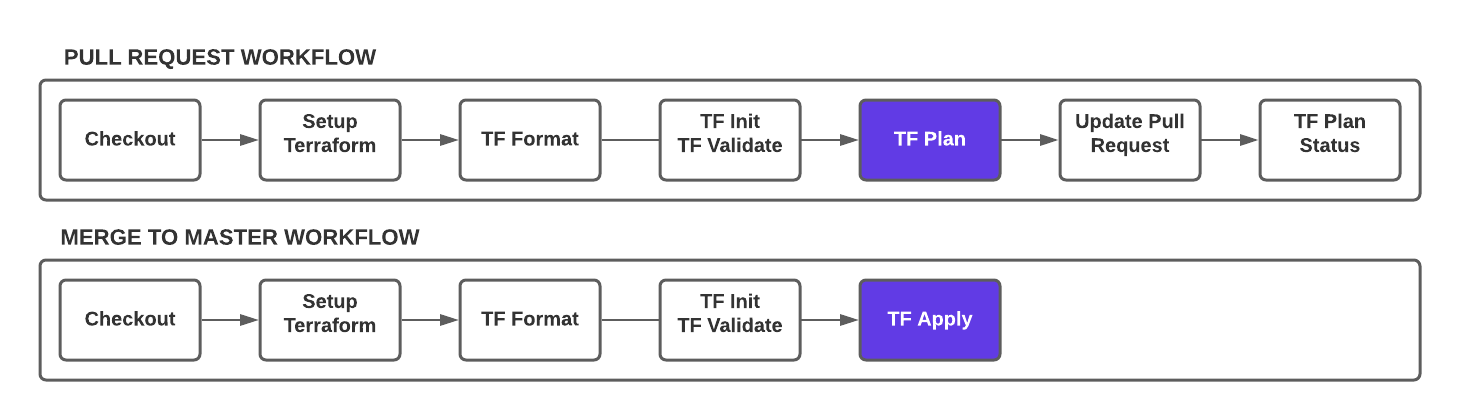

<details><summary>Step 1 - Checkout</summary>

The first action ( `uses: actions/checkout@v2`) allows you to retrieve the project code.

- **Checkout** action should always be the first step. It check outs the current configuration.
    - [`uses`](https://docs.github.com/en/actions/reference/workflow-syntax-for-github-actions#jobsjob_idstepsuses) specifies the action/Docker image to run that specific step.
    - The checkout step "uses" GitHub's `actions/checkout@v2` action.

```yaml
  - name: Checkout
    uses: actions/checkout@v2
```
</details>

<details><summary>Step 2 - Terraform Setup</summary>

- `uses: hashicorp/setup-terraform@v1` retrieves and configures the Terraform CLI used in the GitHub action workflow.
	- The `with` field gives the ability to add Terraform based inputs such as hostname, token, version, and wrapper.
    - We modify the version using the `terraform_version` attribute.
        - By default, the latest stable version of the binary is downloaded.
	- We load the `TF_API_TOKEN` secret as an environment variable, enabling the Terraform CLI to authenticate to Terraform Cloud.

```yaml
  - name: Setup Terraform
    uses: hashicorp/setup-terraform@v1
    with:
      terraform_version: 0.14.0
      cli_config_credentials_token: ${{ secrets.TF_API_TOKEN }}
```
</details>

The next few steps allow for direct interaction with the Terraform CLI via the `run` field.

<details><summary>Step 3 - Terraform Format</summary>

- `Terraform Format` checks whether the configuration has been properly formatted. If the configuration isn't properly formatted this step will produce an error. It enforces Terraform best practices by preventing your team from merging misformatted configuration to `main`.

```yaml
  - name: Terraform Format
    id: fmt
    run: terraform fmt -check
```
</details>

<details><summary>Step 4 - Terraform Init</summary>

- `Terraform Init` initializes the configuration used in the GitHub action workflow.

```yaml
  - name: Terraform Init
    id: init
    run: terraform init -input=false
```
</details>

<details><summary>Step 5 - Terraform Validate</summary>

- `Terraform Validate` Checks that all Terraform configuration files adhere to a canonical format.

```yaml
  - name: Terraform Validate
    id: validate
    run: terraform validate
```
</details>

<details><summary>Step 6 - Terraform Plan</summary>

- `Terraform Plan` generates a Terraform plan. Since `main.tf` defines Terraform Cloud as the backend, this step triggers a remote plan run in the Terraform Cloud. Notice:
	* This step only runs on pull requests. The PR generates a plan. When the PR is merged, that plan will be applied.
	* `continue-on-error: true` - This step will continue even when it errors. This allows the next step to display the plan error message even if this step fails.

```yaml
  - name: Terraform Plan
    id: plan
    if: github.event_name == 'pull_request'
    run: terraform plan -no-color
    continue-on-error: true
```
</details>

<details><summary>Step 7 - Pull Request</summary>

- `Update Pull Request` adds a comment to the pull request with the results of the format, init and plan steps.
    - In addition, it displays the plan output (`steps.plan.outputs.stdout`).
    - This allows your team to review the results of the plan directly in the PR instead of opening Terraform Cloud.
    - This step only runs on pull requests.

```yaml
  - name: Update Pull Request
    uses: actions/github-script@0.9.0
    if: github.event_name == 'pull_request'
    env:
      PLAN: "terraform\n${{ steps.plan.outputs.stdout }}"
    with:
      github-token: ${{ secrets.GITHUB_TOKEN }}
      script: |
        const output = `#### Terraform Format and Style 🖌\`${{ steps.fmt.outcome }}\`
        #### Terraform Initialization ⚙️\`${{ steps.init.outcome }}\`
        #### Terraform Plan 📖\`${{ steps.plan.outcome }}\`

        <details><summary>Show Plan</summary>
        \`\`\`${process.env.PLAN}\`\`\`
        </details>

        *Pusher: @${{ github.actor }}, Action: \`${{ github.event_name }}\`*`;

        github.issues.createComment({
          issue_number: context.issue.number,
          owner: context.repo.owner,
          repo: context.repo.repo,
          body: output
        })
```
</details>

<details><summary>Step 8 - Plan Status</summary>

- **Terraform Plan Status** returns whether a plan was successfully generated or not. This step highlights whenever a plan fails because the "Terraform Plan" step continues on error.

```yaml
  - name: Terraform Plan Status
    if: steps.plan.outcome == 'failure'
    run: exit 1
```
</details>

<details><summary>Step 9 - Terraform Apply</summary>

- `Terraform Apply` applies the configuration. This step will only run when a commit is pushed to `main`.

```yaml
  - name: Terraform Apply
    if: github.ref == 'refs/heads/main' && github.event_name == 'push'
    run: terraform apply -auto-approve
```

* `if: github.ref == 'refs/heads/main' && github.event_name == 'push'` - allows you to launch a step based on one or more conditions.
    * In this example, it needs to be for the `main` branch and for `push` event.

> **TIP:** In a production environment, consider adding "Require status checks to pass before merging" as a [Branch Protection rule](https://docs.github.com/en/enterprise/2.16/admin/developer-workflow/configuring-protected-branches-and-required-status-checks). This adds another layer of protection, ensuring that this workflow successfully completes before changes are merged into `main`.

</details>

---

## Create pull request

* Create a new branch in your forked repo named `update-tfc-backend`.

In [5]:
cd $MAIN_DIR/$WORK_DIR; pwd
git checkout -b 'update-tfc-backend'

### uncomment next line if your branch already exists
# git switch update-tfc-backend

Switched to branch 'update-tfc-backend'
Your branch is up to date with 'origin/update-tfc-backend'.


: 1

* Create a `versions.tf` file with the Terraform Cloud organization and workspace you created earlier. Set the value for `TF_ORG` with your own organization name.

In [11]:
export TF_ORG=pphan
export workspace=test-workspace-triggers

cat << EOF > versions.tf
terraform {
  required_providers {
    random = {
      source = "hashicorp/random"
    }
  }
  backend "remote" {
    organization = "${TF_ORG}"
    workspaces {
      name = "${workspace}"
    }
  }
}

output "workspace" {
  value = "${workspace}"
}
EOF

: 1

Push your changes to the repo.

In [12]:
# see changes
git status

echo "# Add your changes (versions.tf) to your branch's staging area."
git add versions.tf

echo "# Commit these changes with a message."
git commit -m 'Point backend to correct TFC org and workspace'

echo "# Push these changes."
git push
# git push --set-upstream origin update-tfc-backend

On branch update-tfc-backend
Your branch is up to date with 'origin/update-tfc-backend'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   versions.tf

no changes added to commit (use "git add" and/or "git commit -a")
# Add your changes (versions.tf) to your branch's staging area.
# Commit these changes with a message.
[update-tfc-backend 3e6348f] Point backend to correct TFC org and workspace
 1 file changed, 1 insertion(+)
# Push these changes.04l
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 307 bytes | 307.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/phanclan/test-workspace-triggers
   0300774..3e6348f  update-tfc-b

: 1

### Generate a Pull Request

* Next, generate a pull request from the `update-tfc-backend` branch.
	* Go to **GitHub** > **Code**.
    * Click "**Compare & pull request**".
	* From the `base repository` drop-down, choose "**YOUR**" forked repository and `main` branch.
	* Click "**Create pull request"**.

## Verify your GitHub Actions workflow results

* Go to GitHub, navigate to the main page of the repository.
* Under your repository name, click **Actions**.
* In the left sidebar, click the workflow you want to see.
* From the list of workflow runs, click the name of the run you want to see.
* Under **Jobs** or in the visualization graph, click the **Terraform** job.
* Any failed steps are automatically expanded to display the results

---

## Review and Merge pull request

* Navigate to your pull request.
	* Your PR will trigger the Terraform Actions workflow.
	* When the workflow completes, it will add a comment with the outcome of each step and a speculative plan.

<img alt="View pull request with workflow action results and speculative plan." src=https://learn.hashicorp.com/img/terraform/automation/gh-actions-pr-plan.gif width=640>

Terraform plans to create one resource. It will be a random pet name.

## Troubleshooting

Common Errors

* Terraform CLI Version mis-match.
    * Terraform Cloud Workspaces sets the latest version at creation time.
    * `setup-terraform` action downloads the latest version every time.
    * You config files might specify a specific version major and/or minor relese.
    * Make sure all of these are in agreement.
* Credentials
    * Are your Cloud credentials correct and set in the right places?
    * Is your Terraform API token valid?
* Terraform Backend
    * Is organization and workspace defined correctly? Spelling?
    

## Merge pull request

* Click "Merge pull request" and then confirm.

---

## Verify Resources provisioned

You can track the status of the apply job through **GitHub Actions** or **Terraform Cloud**.

### GitHub Actions - Verify workflow results

- In GitHub, go to "**Actions**".
- Then, select the **pull request** you just merged.
- Then, click on the "**Terraform**" workflow.
	- Notice how the "**Terraform Plan**", "**Update Pull Request**" and "**Terraform Plan Status**" steps have been skipped.

<img alt=[image.png] src=attachment:db6b9b2f-da9b-43fc-9840-95896723e151.png width=50%>

- Expand the "**Terraform Apply**" step.
    - Terraform should have one created one `random_pet` resource and displayed the pet name and workspace.
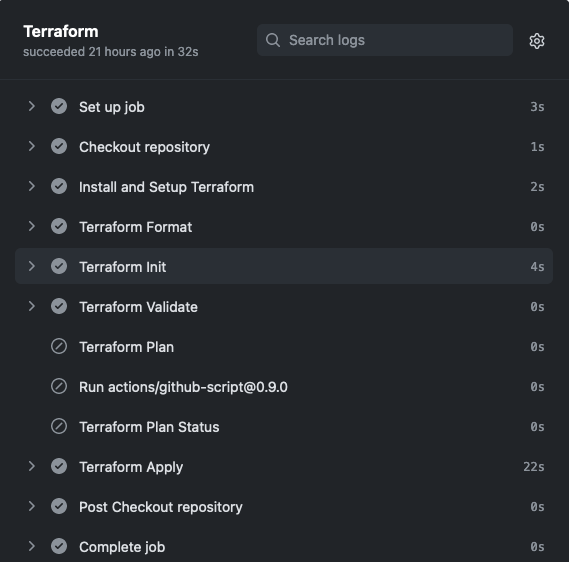

### Terraform Cloud

* In Terraform Cloud, go to the `test-workspace-triggers` workspace.
* Select the **run** triggered by the Actions workflow — this should be your most recent run.
* Wait for the apply to complete, then expand "**Apply finished**".
* Terraform should have one created one `random_pet` resource and displayed the pet name and workspace.

<img src=attachment:1e01a84a-1b5a-4e6b-8795-e7121e356321.png width=50%>
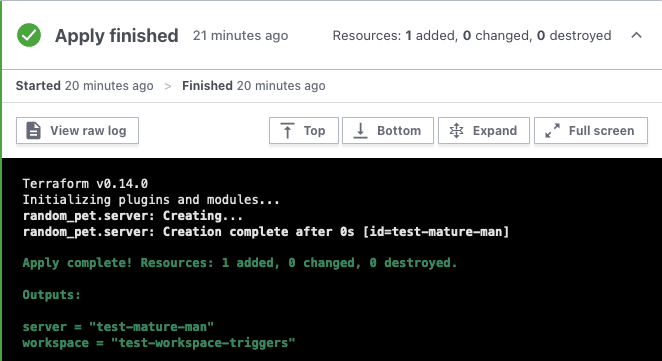

You have successfully set up a complete GitHub Actions workflow to deploy a `random_pet` resource within a Terraform Cloud workspace.

# Monorepo Use Cases

How does Actions work with Terraform Cloud and Monorepos?

Some opportunities to take on:

* Only run workflow when changes are done to specific folder or files.
* Multiple Terraform Cloud Workspaces are tied to the monorepo.


## Disable the current workflow.

We're going to disable the current workflow to create one that works better for monorepos that are associated with multiple Terraform workspaces, modules, etc.

1. Go to your repo.
1. Select **Actions**.
1. Select your workflow (eg `terraform-plan-approve-apply`).
1. Click on the ellipsis `...` and select `Disable workflow`.

<img src=attachment:72843fae-ce38-4d57-86e2-acad2ee32a7f.png width=93>
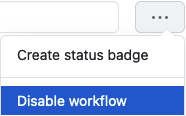

## Composite Pre-requisite

In the `test-workspace-triggers` repository, create a new file called `goodbye.sh`, and add the following example code:

In [ ]:
# Make sure we are in the test-workspace-triggers directory.
cd $MAIN_DIR/$WORK_DIR;pwd

In [105]:
git switch main
mkdir -p $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow
echo 'echo "Goodbye"' > $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow/goodbye.sh

From your terminal, make `goodbye.sh` executable.

In [16]:
chmod +x $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow/goodbye.sh

: 1

Check in your `goodbye.sh` file.

In [106]:
git switch main
git add $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow/goodbye.sh
git commit -m "Add goodbye script"
# make sure you have the latest
git pull
# push your changes
git push

M	.github/actions/terraform-workflow/goodbye.sh
Already on 'main'
Your branch is up to date with 'origin/main'.
[main c1a492b] Add goodbye script
 1 file changed, 1 insertion(+)
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
Already up to date.
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing obj

: 1

## 1. Create an action metadata file

1. In the `test-workspace-triggers` repository, create a new file called `action.yml`. NOTE: Must be named `action.yml` or `action.yaml`.
1. Add the following example code. For more information about this syntax, see "[runs for a composite run steps](https://docs.github.com/en/actions/creating-actions/metadata-syntax-for-github-actions#runs-for-composite-run-steps-actions)".

In [123]:
mkdir -p $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow
git switch main
cat << "EOF" > $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow/action.yml
name: 'terraform-plan-approve-apply'
description: 'Common workflow for Terraform'
inputs:
  working-directory:
    description: 'Working directory for this action'
    required: false
    default: '.'
outputs:
  fmt:
    description: "Status of terraform format"
    value: ${{ steps.fmt.outputs.test }}
  init:
    description: "Status of terraform init"
    value: ${{ steps.init.outputs.test }}
  validate:
    description: "Status of terraform validate"
    value: ${{ steps.validate.outputs.test }}

runs:
  using: "composite"
  steps:
    - name: Goodbye Script
      run: ${{ github.action_path }}/goodbye.sh
      shell: bash

    - name: Terraform Format
      id: fmt
      run: if terraform fmt -check; then echo "::set-output name=test::success"; else echo "::set-output name=test::fail"; fi
      shell: bash
      working-directory: ${{ inputs.working-directory }}
    - name: Terraform Init
      id: init
      run: if terraform init -input=false; then echo "::set-output name=test::success"; else echo "::set-output name=test::fail"; fi
      shell: bash
      working-directory: ${{ inputs.working-directory }}
    - name: Terraform Validate
      id: validate
      run: |
        if terraform validate -no-color; then
        echo "::set-output name=test::success"
        else
        echo "::set-output name=test::fail"
        fi
      shell: bash
      working-directory: ${{ inputs.working-directory }}
EOF

Already on 'main'
Your branch is up to date with 'origin/main'.


: 1

This file:
* Mandatory - `name`, `descriptions`, and `runs`
* Optional - `input` and `outputs`
  * defines the `who-to-greet` input
  * defines the `working-directory` input
* `using: "composite"` - makes this work
* `::set-output name=test::<message>` maps the success/fail messages to the `fmt`, `init`, `validate` output variables
* runs the `goodbye.sh` script
* tells the runner how to execute the composite run steps action.

For more information about managing outputs, see "[`outputs` for a composite run steps](https://docs.github.com/en/actions/creating-actions/metadata-syntax-for-github-actions#outputs-for-composite-run-steps-actions)".

For more information about how to use `github.action_path`, see "[github context](https://docs.github.com/en/actions/reference/context-and-expression-syntax-for-github-actions#github-context)".

#### Supported Properties
* `name`
* `id`
* `run`
* `env`
* `shell`
* `working-directory`
* `input` and `outputs`

#### Currenlty Unsupported:
* `uses`, conditionals `if`, `continue-on-error`, `outcome` of a composite step, and timeouts

Check in your `action.yml` file.

In [124]:
git switch main
git add $MAIN_DIR/$WORK_DIR/.github/actions/terraform-workflow/action.yml
git commit -m "Add/update action.yml"
git push

Already on 'main'
Your branch is up to date with 'origin/main'.
On branch main4l
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


: 1

Add a tag. This example uses a tag called `v1`. For more information, see "[About actions](https://docs.github.com/en/actions/creating-actions/about-actions#using-release-management-for-actions)."

In [71]:
git tag -a -m "Description of this release" v1.1
git push --follow-tags

Enumerating objects: 1, done.
Counting objects: 100% (1/1), done.
Writing objects: 100% (1/1), 172 bytes | 172.00 KiB/s, done.
Total 1 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/phanclan/test-workspace-triggers
 * [new tag]         v1.1 -> v1.1


: 1

## Testing out your action in a workflow

The following workflow code uses the completed hello world action that you made in "**Create an action metadata file**".

Copy the workflow code into a `.github/workflows/main.yml` file in another repository, but replace `actions/hello-world-composite-run-steps-action@v1` with the repository and tag you created. You can also replace the `who-to-greet` input with your name.

### (testing) Create workflow files with bash arrays - DELETE

In [99]:
### Test for creating multiple workflow files based on array.
echo "start"
declare -A array
array[sub-1]=sub-1
array[sub-2a]=sub-1/sub-2a

echo "start 2"
for i in "${!array[@]}"; do
    echo "${i} <--> ${array[$i]}"
done

### Create workflow file
cat << "EOF" > .github/workflows/sub-2a.yml
on:
  push:
    paths:
      - 'test-workspace-triggers/sub-1/sub-2a/*'
jobs:
  hello_world_job:
    runs-on: ubuntu-latest
    name: A job to say hello
    steps:
      - name: Checkout repository
        uses: actions/checkout@v2
      - name: Install and Setup Terraform
        uses: hashicorp/setup-terraform@v1
        with:
          terraform_version: 0.14.0
          cli_config_credentials_token: ${{ secrets.TF_API_TOKEN }}
      - id: foo
        uses: ./.github/actions/terraform-workflow # actions/hello-world-composite-run-steps-action@v1
        with:
          working-directory: 'test-workspace-triggers/sub-1/sub-2a'
          who-to-greet: 'Mona the Octocat'
      - run: echo random-number ${{ steps.foo.outputs.random-number }}
        shell: bash
EOF

: 1

### 2. Create workflow files with Terraform templates


We need to create workflow files for each Terraform workspace. Each workflow will use the action metadata file. This saves us from having to makes lots of changes when we want to change our pipeline.

To automate this, we will use Terraform's templating ability to create these files. If you have hundreds of workspaces, doing this by hand would not be fun.

#### 2a. Create Terraform Template file

In [129]:
git switch main
mkdir -p $MAIN_DIR/$WORK_DIR/create-workflows/templates
cat << "EOF" > $MAIN_DIR/$WORK_DIR/create-workflows/templates/workspace_workflow.tpl
on:
  push:
    branches:
      - main
    paths:
      - '${path}'
  pull_request:
    paths:
      - '${path}'
defaults:
  run:
    shell: bash
jobs:
  hello_world_job:
    runs-on: ubuntu-latest
    name: Terraform Plan Apply
    steps:
      - name: Checkout repository
        uses: actions/checkout@v2
      - name: Install and Setup Terraform
        uses: hashicorp/setup-terraform@v1
        with:
          terraform_version: 0.14.0
          cli_config_credentials_token: $${{ secrets.TF_API_TOKEN }}

      - name: Terraform Format Init Validate Composite Action
        id: foo
        uses: ./.github/actions/terraform-workflow
        with:
          working-directory: '${working_directory}'
      - name: Terraform Plan
        id: plan
        if: github.event_name == 'pull_request'
        run: terraform plan -no-color -input=false
        working-directory: '${working_directory}'
        continue-on-error: true
      - name: Update Pull Request
        uses: actions/github-script@0.9.0
        if: github.event_name == 'pull_request'
        env:
          PLAN: "terraform\n$${{ steps.plan.outputs.stdout }}"
        with:
          github-token: $${{ secrets.GITHUB_TOKEN }}
          script: |
            const output = `#### Terraform Format and Style 🖌\`$${{ steps.foo.outputs.fmt }}\`
            #### Terraform Initialization ⚙️\`$${{ steps.foo.outputs.init }}\`
            #### Terraform Validation 🤖\`$${{ steps.foo.outputs.validate }}\`
            #### Terraform Plan 📖\`$${{ steps.plan.outcome }}\`

            <details><summary>Show Plan</summary>

            \`\`\`\n
            $${process.env.PLAN}
            \`\`\`
            </details>

            *Pusher: @$${{ github.actor }}, Action: \`$${{ github.event_name }}\`*`;

            github.issues.createComment({
              issue_number: context.issue.number,
              owner: context.repo.owner,
              repo: context.repo.repo,
              body: output
            })
      - name: Terraform Plan Status
        if: steps.plan.outcome == 'failure'
        run: exit 1
      - name: Terraform Apply
        if: github.ref == 'refs/heads/main' && github.event_name == 'push'
        run: terraform apply -auto-approve -input=false
        working-directory: '${working_directory}'
EOF

Already on 'main'
Your branch is up to date with 'origin/main'.


: 1

* `with:` - pass parameters
* `$${{ steps.foo.outputs.fmt }} $${{ steps.foo.outputs.tf_init }} $${{ steps.foo.outputs.random-number }}` 

#### 2b. Create Terraform Config

Create the terraform configuration for the `local_file` resource.

In [61]:
# mkdir -p create-workflows
cat << "EOF" > $MAIN_DIR/$WORK_DIR/create-workflows/main.tf
## main.tf
resource "local_file" "dynamic" {
  for_each   = local.path_to_workspace_map
  content    = templatefile("${path.module}/templates/workspace_workflow.tpl", each.value)
  filename       = "${local.local_filepath}/${each.key}.yml"
}

## variables.tf
#variable "path_to_workspace_map" {}
#variable "local_filepath" {}
## terraform.tfvars

locals {
    path_to_workspace_map = {
      "root"  = {
          path = "*", uses = "./.github/actions/terraform-workflow", working_directory = "." },
      "sub-1"  = {
          path = "sub-1/*", uses = "./.github/actions/terraform-workflow", working_directory = "sub-1" },
      "sub-2a" = {
          path = "sub-1/sub-2a/*", uses = "./.github/actions/terraform-workflow", working_directory = "sub-1/sub-2a" },
      "sub-2b" = { path = "sub-1/sub-2b/*", uses = "./.github/actions/terraform-workflow", working_directory = "sub-1/sub-2b" },
    }
    local_filepath = "../.github/workflows"
}
EOF

: 1

#### 2c. Run Terraform to create workflow files

In [130]:
terraform -chdir=create-workflows init
# terraform -chdir=create-workflows plan
terraform -chdir=$MAIN_DIR/$WORK_DIR/create-workflows apply -auto-approve


Initializing the backend...

Initializing provider plugins...
- Reusing previous version of hashicorp/local from the dependency lock file
- Installing hashicorp/local v2.1.0...
- Installed hashicorp/local v2.1.0 (self-signed, key ID 34365D9472D7468F)

Partner and community providers are signed by their developers.
If you'd like to know more about provider signing, you can read about it here:
https://www.terraform.io/docs/plugins/signing.html

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.
local_file.dynamic["root"]: Refreshing state... [id=f50f328a1f90c7f8ebd6a5f4c1cfe3a243434901]
local_file.dynamic["su

: 1

You should see workflow files in your `.github/workflows` directory.

In [32]:
ls -la $MAIN_DIR/$WORK_DIR/.github/workflows

total 40
drwxr-xr-x  7 pephan  wheel   224 Jul 21 22:28 .
drwxr-xr-x  4 pephan  wheel   128 Jul 19 16:31 ..
-rwxr-xr-x  1 pephan  wheel  2407 Jul 21 22:28 root.yml
-rwxr-xr-x  1 pephan  wheel  2431 Jul 21 22:28 sub-1.yml
-rwxr-xr-x  1 pephan  wheel  2466 Jul 21 22:28 sub-2a.yml
-rwxr-xr-x  1 pephan  wheel  2466 Jul 21 22:28 sub-2b.yml
-rw-r--r--  1 pephan  wheel  2690 Jul 19 16:28 terraform.yml


: 1

Sample Output

```shell
drwxr-xr-x  7 pephan  wheel   224 Jul 19 16:47 .
drwxr-xr-x  4 pephan  wheel   128 Jul 19 16:31 ..
-rwxr-xr-x  1 pephan  wheel  2322 Jul 19 16:47 root.yml
-rwxr-xr-x  1 pephan  wheel  2346 Jul 19 16:47 sub-1.yml
-rwxr-xr-x  1 pephan  wheel  2374 Jul 19 16:47 sub-2a.yml
-rwxr-xr-x  1 pephan  wheel  2374 Jul 19 16:47 sub-2b.yml
-rw-r--r--  1 pephan  wheel  2690 Jul 19 16:28 terraform.yml
```

#### 2d. Add file, commit, and push changes.

In [131]:
git switch main
git add $MAIN_DIR/$WORK_DIR/.github/workflows/*.yml
git commit -am "add/update workspace workflows"
git push

M	.github/workflows/root.yml
M	.github/workflows/sub-1.yml
M	.github/workflows/sub-2a.yml
M	.github/workflows/sub-2b.yml
M	create-workflows/templates/workspace_workflow.tpl
M	create-workflows/terraform.tfstate
M	create-workflows/terraform.tfstate.backup
Already on 'main'
Your branch is up to date with 'origin/main'.
[main f4932fe] add/update workspace workflows
 7 files changed, 28 insertions(+), 38 deletions(-)
Enumerating objects: 23, done.
Counting objects: 100% (23/23), done.
Delta compression using up to 12 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.53 KiB | 1.53 MiB/s, done.
Total 12 (delta 7), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (7/7), completed with 7 local objects.
To https://github.com/phanclan/test-workspace-triggers
   edee347..f4932fe  main -> main


: 1

## Test out changes for specific workspaces

### 3. Prep for Modifications

We are going to utilize a bash function to facilitate our changes to our multiple repos. Change the `TF_ORG` value below to your own TFC organization.

In [121]:
export TF_ORG=pphan

#==> Start Function
update_repo () {

# git switch "$1" || git checkout -b "$1"
git branch "$1"
git switch "$1"

cat << EOF > $MAIN_DIR/$WORK_DIR/$2$1/versions.tf
terraform {
  required_providers {
    random = {
      source = "hashicorp/random"
    }
  }
  backend "remote" {
    organization = "${TF_ORG}"

    workspaces {
      name = "$1"
    }
  }
}
output "workspace" {
  value = "$1 `date +%Y%m%d%H%M`"
}
EOF

#done

# Push changes to repo
git status
git add $MAIN_DIR/$WORK_DIR/$2$1/versions.tf
git commit -am "Update $1 `date +%Y%m%d%H%M`"
git push --set-upstream origin $1

# Delete branch. If we make changes in main, we want branch to have the latest commit.
git switch main && git branch -D "$1"
}
#==> End Function

: 1

### 4. Modify sub-1

Now let's update `sub-1`. For the function we need to pass the folder and the parent folder(s).

```shell
update_repo <folder> [<folder_prefix>]
```

In [128]:
update_repo sub-1

Switched to branch 'sub-1'
On branch sub-1
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   sub-1/versions.tf

no changes added to commit (use "git add" and/or "git commit -a")
[sub-1 cb073da] Update sub-1 202107221543
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 358 bytes | 358.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: 
remote: Create a pull request for 'sub-1' on GitHub by visiting:
remote:      https://github.com/phanclan/test-workspace-triggers/pull/new/sub-1
remote: 
To https://github.com/phanclan/test-workspace-triggers
 * [new branch]      sub-1 -> sub-1
Branch 'sub-1' set up 

: 1

1. Go to **Repo > Pull requests**.
1. Select "**Compare & pull**" request. Or select "**New pull request**"
1. For `base:` select your fork.
1. For `compare`: select `sub-1` branch.
1. Click "**Create pull request**".

1. From your repository, click the "**Actions**" tab, and select the latest workflow run
2. The output should include:
	* ``"Hello Mona the Octocat"``
	* Install and Setup Terraform
	* the result of the "Goodbye" script, 
	* Terraform Plan
	* Update Pull Request

### Modify sub-2a

Now let's update `sub-2a`. For the function we need to pass the folder and the parent folder(s).

In [132]:
update_repo sub-2a sub-1/

Switched to branch 'sub-2a'
On branch sub-2a
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   sub-1/sub-2a/versions.tf

no changes added to commit (use "git add" and/or "git commit -a")
[sub-2a 4c25c1b] Update sub-2a 202107221613
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 12 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 439 bytes | 439.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: 
remote: Create a pull request for 'sub-2a' on GitHub by visiting:
remote:      https://github.com/phanclan/test-workspace-triggers/pull/new/sub-2a
remote: 
To https://github.com/phanclan/test-workspace-triggers
 * [new branch]      sub-2a -> sub-2a
Branch 

: 1

1. Go to **Repo > Pull requests**.
1. Select "**Compare & pull**" request. Or select "**New pull request**"
1. For `base:` select your fork.
1. For `compare`: select `sub-2a` branch.
1. Click "**Create pull request**".

### Modify sub-2b

In [50]:
update_repo sub-2b sub-1/

Switched to branch 'sub-2b'
On branch sub-2b
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   sub-1/sub-2b/versions.tf

no changes added to commit (use "git add" and/or "git commit -a")
[sub-2b 00243bf] Update sub-2b 202107220917
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 19, done.
Counting objects: 100% (19/19), done.
Delta compression using up to 12 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (11/11), 1.02 KiB | 1.02 MiB/s, done.
Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
remote: 
remote: Create a pull request for 'sub-2b' on GitHub by visiting:
remote:      https://github.com/phanclan/test-workspace-triggers/pull/new/sub-2b
remote: 
To https://github.com/phanclan/test-workspace-triggers
 * [new branch]      sub-2b -> sub-2b
Br

: 1

1. Go to **Repo > Pull requests**.
1. Select "**Compare & pull**" request. Or select "**New pull request**"
1. For `base:` select your fork.
1. For `compare`: select `sub-2b` branch.
1. Click "**Create pull request**".

## Verify path based workflow

<!-- <details><summary>Generate a Pull Request</summary>

* Next, generate a pull request from the `sub-1` branch.
	* Go to **GitHub** > **Code**.
    * Click "**Compare & pull request**".
	* From the `base repository` drop-down, choose "**YOUR**" forked repository and `main` branch.
	* Click "**Create pull request"**.
</details> -->

**Verify your GitHub Actions workflow results**

* Go to **GitHub**, navigate to the main page of the repository.
* Click **Actions**.
* In the left sidebar, click the workflow you want to see. `sub-1`
* From the list of workflow runs, click the name of the run you want to see.
    * You probably want the latest one on top.
* Under **Jobs** or in the visualization graph, click the **Terraform** job.
* Any failed steps are automatically expanded to display the results

### Verify Pull Request Workflow Results

* You should have 4 new workflows: root.yml, sub-1.yml, sub-2a.yml, and sub-2b.yml.
* Only one workflow was triggered by a Pull Request: eg `sub-1`
  * Pull requests should not trigger un-necessary activity if filtered correctly.
* The terraform plan output performed in a working directory is copied to the relevant PR.

### Review and Merge pull request

* Navigate to your pull request. eg `sub-1`
	* Your PR will trigger the Terraform Actions workflow.
	* When the workflow completes, it will add a comment with the outcome of each step and a speculative plan.

Terraform plans to create one resource. It will be a random pet name.

### Merge pull request

* Click "**Merge pull request**" and then confirm.

###Verify Resources provisioned

You can track the status of the apply job through **GitHub Actions** or **Terraform Cloud**.

### GitHub Actions - Verify workflow results

- In GitHub, go to "**Actions**".
- Then, select the **pull request** you just merged.
- Then, click on the "**Terraform**" workflow.
	- Notice how the "**Terraform Plan**", "**Update Pull Request**" and "**Terraform Plan Status**" steps have been skipped.
- Expand the "**Terraform Apply**" step.
    - Terraform should have one created one `random_pet` resource and displayed the pet name and workspace.
* Only one workflow was triggered by a Merge: eg `sub-1`


### Terraform Cloud

* In Terraform Cloud, go to the `test-workspace-triggers` workspace.
* Select the **run** triggered by the Actions workflow — this should be your most recent run.
* Wait for the apply to complete, then expand "**Apply finished**".
* Terraform should have one created one `random_pet` resource and displayed the pet name and workspace.


## Destroy resources

Remember to destroy the resources and Terraform Cloud workspace you created for this tutorial.

* Go to the `gh-actions-demo` workspace.
* Queue a destroy plan and apply it.
    * Click **Settings > Destruction and Deletion**.
    * Click "**Queue destroy plan**".
    * Confirm by entering the name of the workspace: eg `gh-actions-demo`
    * Click "**Queue destroy plan**".
    * Click "**Confirm and Apply**".
    * Click "**Confirm Plan**"
* Then, delete the workspace from Terraform Cloud.

### GitHub Actions

* GitHub - Disable Actions if you no longer need it.
	* Go to **Repo > Settings > Actions**
	* Select **Disable Actions**. Click **Save**.

For a more detailed tutorial on destroying resources on Terraform Cloud, reference the [Clean up Cloud Resources tutorial](https://learn.hashicorp.com/tutorials/terraform/cloud-destroy?in=terraform/cloud-get-started).

---

## Next steps

In this tutorial, you deployed a publicly available web server by automating your Terraform Cloud workflow with GitHub Actions. The resources below will help you customize the Actions workflow to fit your real-world use cases.

- [Setup Terraform Action Documentation](https://github.com/marketplace/actions/hashicorp-setup-terraform)
- [Continuous Integration for Terraform Modules with GitHub Actions](https://www.hashicorp.com/blog/continuous-integration-for-terraform-modules-with-github-actions/)
- [Terraform and CircleCI](/tutorials/terraform/circle-ci) tutorial guides you through building an automated Terraform workflow using AWS S3 as a backend.
- [Running Terraform in Automation](/tutorials/terraform/automate-terraform)

## Clean Up

In [189]:
cd $MAIN_DIR
echo "Delete local repos"
# rm -rf $MAIN_DIR/$WORK_DIR

Delete local repos
/Users/pephan/OneDrive/code/vault_transit_test/hc_demos-jupyter/Terraform


: 1

* Delete your remote branch from the UI.
* Delete your branch from the CLI.

```shell
# Delete local branch
git branch -d <local_branch>
# Delete remote branch
git push origin --delete <remote_branch_name>
```

## Resources

### Actions
* dflook/terraform-github-actions - https://github.com/dflook/terraform-github-actions
* https://github.com/marketplace/actions/hashicorp-setup-terraform
* 

### Monorepo
https://translate.google.com/translate?hl=en&sl=fr&u=http://blog.ippon.fr/2021/04/14/github-actions-en-action/&prev=search&pto=aue

* GitHub Roadmap with actions filter
	* https://github.com/github/roadmap/projects/1?card_filter_query=action
* https://www.kmruddy.com/2020/terraform-github-actions-integration/

Super-linter
https://github.com/github/super-linter

```shell
docker run --rm \
    -e RUN_LOCAL=true \
    -e VALIDATE_TERRAFORM=true \
    -e VALIDATE_ANSIBLE=true \
    -v $PWD:/tmp/lint github/super-linter
```

### Misc

* [Running Terraform in Automation](https://learn.hashicorp.com/tutorials/terraform/automate-terraform)
* https://github.com/marketplace/actions/paths-changes-filter